<a href="https://colab.research.google.com/github/jyanivaddi/ERA_V1/blob/master/session_12/s12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Download our code repository and install python dependencies

In [1]:
!git clone "https://github.com/jyanivaddi/ERA_V1.git"
!git pull
!git clone "https://github.com/jyanivaddi/dl_hub.git"
!git pull
!pip install --quiet "torchinfo" "seaborn" "pytorch-lightning" "torchmetrics" "lightning-bolts"
!pip install --quiet "prettytable"
!pip install --quiet "torch_lr_finder"
!pip install --quiet "grad-cam"

fatal: destination path 'ERA_V1' already exists and is not an empty directory.
fatal: not a git repository (or any of the parent directories): .git
fatal: destination path 'dl_hub' already exists and is not an empty directory.
fatal: not a git repository (or any of the parent directories): .git


Add all the imports:

In [2]:
from __future__ import print_function
import os
import sys
from typing import Any
sys.path.append("dl_hub/models")
sys.path.append("ERA_V1/session_12")
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import Dataset, DataLoader
import albumentations as A
import albumentations.augmentations as AA
from albumentations.pytorch import ToTensorV2
from dl_hub.models.custom_resnet import CustomResnet, model_summary

Lightning related imports

In [3]:
from pl_bolts.datamodules import CIFAR10DataModule
from pl_bolts.transforms.dataset_normalizations import cifar10_normalization
from pytorch_lightning import LightningModule, LightningDataModule, Trainer, seed_everything
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from pytorch_lightning.loggers import CSVLogger
from torch.optim.lr_scheduler import OneCycleLR
from torch.optim.swa_utils import AveragedModel, update_bn
from torchmetrics.functional import accuracy

/usr/local/lib/python3.10/dist-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:34: UnderReviewWarning: The feature generate_power_seq is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  "lr_options": generate_power_seq(LEARNING_RATE_CIFAR, 11),
/usr/local/lib/python3.10/dist-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:92: UnderReviewWarning: The feature FeatureMapContrastiveTask is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  contrastive_task: Union[FeatureMapContrastiveTask] = FeatureMapCon

Set up environment and add random seed

In [4]:
GLOBAL_SEED = 42
seed_everything(GLOBAL_SEED)
PATH_DATASETS = os.environ.get("PATH_DATASETS", ".")
BATCH_SIZE = 512 if torch.cuda.is_available() else 64
NUM_WORKERS = 2

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
INFO:lightning_fabric.utilities.seed:Global seed set to 42


Define data module

In [5]:
import numpy as np
from typing import List
from torch.utils.data import random_split

class CifarDatasetWAlbumentations(Dataset):

    def __init__(self, dataset, transforms=None):
        self.transforms = transforms
        self.dataset = dataset


    def __len__(self) -> int:
        return len(self.dataset)


    def __getitem__(self, index) -> Any:
        image, label = self.dataset[index]
        image = np.array(image)
        if self.transforms is not None:
            image = self.transforms(image=image)["image"]
        return (image, label)

class CustomCifar10DataModule(LightningDataModule):
    def __init__(self, data_dir = PATH_DATASETS, val_split=0.2):
        # Initialize the class. Set up the datadir, image dims, and num classes
        super().__init__()
        self.data_dir = data_dir
        self.dims = (3, 32, 32)
        self.num_classes = 10
        self.val_split = val_split
        self.train_transforms = A.Compose([
            A.Normalize(mean=(0.491,0.482,0.447),std=(0.247,0.244,0.262), always_apply=True),
            A.transforms.PadIfNeeded(min_height=40, min_width=40, always_apply=True),
            AA.crops.transforms.RandomCrop(height=32, width=32, always_apply=True),
            A.HorizontalFlip(),
            AA.dropout.coarse_dropout.CoarseDropout(max_holes = 1,
                                                    max_height=8,
                                                    max_width=8,
                                                    min_holes = 1,
                                                    min_height=8,
                                                    min_width=8,
                                                    fill_value=(0.491, 0.482, 0.447),
                                                    mask_fill_value = None),

                        ToTensorV2()])
        self.test_transforms = A.Compose([
            A.Normalize(mean=(0.491,0.482,0.447),std=(0.247,0.244,0.262), always_apply=True),
            ToTensorV2(),])
        self.val_transforms = self.test_transforms

    def _split_dataset(self, dataset: Dataset, train: bool = True) -> Dataset:
        """Splits the dataset into train and validation set."""
        len_dataset = len(dataset)
        splits = self._get_splits(len_dataset)
        dataset_train, dataset_val = random_split(dataset, splits, generator=torch.Generator().manual_seed(GLOBAL_SEED))
        if train:
            return dataset_train
        return dataset_val

    def _get_splits(self, len_dataset: int) -> List[int]:
        """Computes split lengths for train and validation set."""
        if isinstance(self.val_split, int):
            train_len = len_dataset - self.val_split
            splits = [train_len, self.val_split]
        elif isinstance(self.val_split, float):
            val_len = int(self.val_split * len_dataset)
            train_len = len_dataset - val_len
            splits = [train_len, val_len]
        else:
            raise ValueError(f"Unsupported type {type(self.val_split)}")

        return splits

    def prepare_data(self):
        # Download the dataset
        CIFAR10(self.data_dir, train=True, download=True)
        CIFAR10(self.data_dir, train=False, download=True)

    def setup(self, stage=None):
        # Assign train/val datasets
        if stage == 'fit' or stage is None:
            #self.train_dataset = CifarDatasetWAlbumentations(CIFAR10(self.data_dir, train=True),transforms = self.train_transforms)
            #self.val_dataset = CifarDatasetWAlbumentations(CIFAR10(self.data_dir, train=True), transforms=self.test_transforms)

            dataset_train = CifarDatasetWAlbumentations(CIFAR10(self.data_dir, train=True),transforms = self.train_transforms)
            dataset_val = CifarDatasetWAlbumentations(CIFAR10(self.data_dir, train=True), transforms=self.val_transforms)

            # Split
            self.train_dataset = self._split_dataset(dataset_train)
            self.val_dataset = self._split_dataset(dataset_val, train=False)

        if stage == 'test' or stage:
            self.test_dataset = CifarDatasetWAlbumentations(CIFAR10(self.data_dir, train=False), transforms=self.test_transforms)

    def train_dataloader(self):
        return DataLoader(self.train_dataset,
                          batch_size=BATCH_SIZE,
                          num_workers=NUM_WORKERS,
                          shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset,
                          batch_size=BATCH_SIZE,
                          num_workers=NUM_WORKERS)

    def test_dataloader(self):
        return DataLoader(self.test_dataset,
                          batch_size=BATCH_SIZE,
                          num_workers=NUM_WORKERS)

In [6]:
cifar10_dm = CustomCifar10DataModule(
    data_dir = PATH_DATASETS,
    val_split = 0.1
)
cifar10_dm.prepare_data()
cifar10_dm.setup()
len(cifar10_dm.val_dataset)
len(cifar10_dm.train_dataset)

Files already downloaded and verified
Files already downloaded and verified


45000

Let's build the Lightning ⚡ Module!

In [26]:
class LitResnet(LightningModule):
    def __init__(self, lr=0.01, drop_out_probability=0.02, num_classes=10,
                 base_channels=3, epochs=20):
        super().__init__()

        self.save_hyperparameters()
        self.model = CustomResnet(base_channels=base_channels,
                                  num_classes=num_classes,
                                  drop_out_probability=drop_out_probability)
        self.optimizer = None
        self.scheduler_dict = None
        self.epochs = epochs

    def set_optimizer(self, optimizer):
        self.optimizer = optimizer

    def set_scheduler_dict(self, scheduler_dict):
        self.scheduler_dict = scheduler_dict

    def forward(self, x):
        return self.model.forward(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        #loss = nn.CrossEntropyLoss(logits, y, reduction='mean')
        loss = F.nll_loss(logits, y)
        preds = torch.argmax(logits, dim=1)
        train_acc = accuracy(preds, y,"multiclass", num_classes=10)
        self.log("train_loss", loss, prog_bar=True)
        self.log("train_acc", train_acc, prog_bar=True)
        return loss

    def evaluate(self, batch, stage=None):
        x, y = batch
        logits = self(x)
        #loss = nn.CrossEntropyLoss(logits, y, reduction='mean')
        loss = F.nll_loss(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = accuracy(preds, y,"multiclass", num_classes=10)

        if stage:
            self.log(f"{stage}_loss", loss, prog_bar=True)
            self.log(f"{stage}_acc", acc, prog_bar=True)

    def validation_step(self, batch, batch_idx):
        self.evaluate(batch, "val")

    def test_step(self, batch, batch_id):
        self.evaluate(batch, "test")

    def configure_optimizers(self):
        return {"optimizer": self.optimizer, "lr_scheduler": self.scheduler_dict}


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Get Best LR

  0%|          | 0/200 [00:00<?, ?it/s]

/content/dl_hub/models/custom_resnet.py:161: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.93E-02


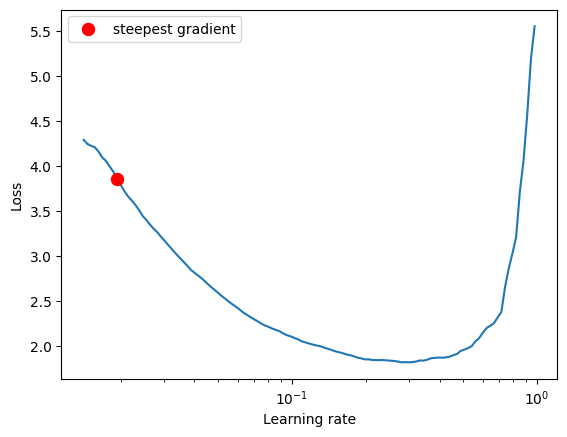

In [27]:
from torch_lr_finder import LRFinder


def find_best_lr(model, train_loader, optimizer, criterion, device):
    lr_finder = LRFinder(model, optimizer, criterion, device)
    lr_finder.range_test(train_loader, end_lr=10, num_iter=200, step_mode='exp')
    lr_finder.plot()
    lr_finder.reset()
    return lr_finder.history

drop_out_probability=0.02
dummy_model = LitResnet(lr=0.01,base_channels=3, num_classes=10,
                  drop_out_probability=drop_out_probability)
tl = DataLoader(cifar10_dm.train_dataset,
                          batch_size=BATCH_SIZE,
                          num_workers=NUM_WORKERS,
                          shuffle=True)
optimizer = optim.Adam(dummy_model.parameters(),lr=0.01, weight_decay=1e-4)
criterion = F.nll_loss
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
lr_history = find_best_lr(dummy_model, tl, optimizer, criterion, device)

Define the model, optimizer and scheduler

In [31]:
NUM_EPOCHS = 24
drop_out_probability=0.02
resnet_model = LitResnet(lr=0.01,base_channels=3, num_classes=10,
                  drop_out_probability=drop_out_probability, epochs=NUM_EPOCHS)
resnet_model.set_optimizer(optim.Adam(resnet_model.parameters(),
                               lr=resnet_model.hparams.lr,
                               weight_decay=1e-4))
steps_per_epoch = len(cifar10_dm.train_dataset) // BATCH_SIZE
max_epochs = 24
resnet_model.set_scheduler_dict({
    "scheduler": OneCycleLR(
        resnet_model.optimizer,
        max_lr = 1.87E-2,
        epochs=resnet_model.epochs,
        steps_per_epoch=steps_per_epoch,
        pct_start = 5./resnet_model.epochs,
        div_factor=2000,
        final_div_factor=1,
        three_phase=False,
        anneal_strategy='linear',
        verbose=True),
    "interval": "step",
    })

Adjusting learning rate of group 0 to 9.3500e-06.


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [32]:
resnet_model.configure_optimizers()

{'optimizer': Adam (
 Parameter Group 0
     amsgrad: False
     base_momentum: 0.85
     betas: (0.95, 0.999)
     capturable: False
     differentiable: False
     eps: 1e-08
     foreach: None
     fused: None
     initial_lr: 9.35e-06
     lr: 9.35e-06
     max_lr: 0.0187
     max_momentum: 0.95
     maximize: False
     min_lr: 9.35e-06
     weight_decay: 0.0001
 ),
 'lr_scheduler': {'scheduler': <torch.optim.lr_scheduler.OneCycleLR at 0x78d7a1075990>,
  'interval': 'step'}}

In [ ]:
steps_per_epoch = len(cifar10_dm.train_dataset) // BATCH_SIZE
trainer = Trainer(
    max_epochs=resnet_model.epochs,
    max_steps = steps_per_epoch*resnet_model.epochs,
    accelerator='auto',
    devices = 1 if torch.cuda.is_available() else None,
    logger = CSVLogger(save_dir="logs/"),
    log_every_n_steps = 1,
    callbacks=[LearningRateMonitor(logging_interval='step'),
               TQDMProgressBar(refresh_rate=10)],
    num_sanity_val_steps=0)

trainer.fit(resnet_model, cifar10_dm)
trainer.test(resnet_model, datamodule = cifar10_dm)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Files already downloaded and verified
Files already downloaded and verified


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type         | Params
---------------------------------------
0 | model | CustomResnet | 6.6 M 
---------------------------------------
6.6 M     Trainable params
0         Non-trainable params
6.6 M     Total params
26.292    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 2.8086e-03.
Adjusting learning rate of group 0 to 2.8517e-03.


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78d7e6f85240>

Adjusting learning rate of group 0 to 2.8948e-03.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78d7e6f85240>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid

Adjusting learning rate of group 0 to 2.9378e-03.
Adjusting learning rate of group 0 to 2.9809e-03.
Adjusting learning rate of group 0 to 3.0240e-03.
Adjusting learning rate of group 0 to 3.0670e-03.
Adjusting learning rate of group 0 to 3.1101e-03.
Adjusting learning rate of group 0 to 3.1532e-03.
Adjusting learning rate of group 0 to 3.1962e-03.
Adjusting learning rate of group 0 to 3.2393e-03.
Adjusting learning rate of group 0 to 3.2824e-03.
Adjusting learning rate of group 0 to 3.3254e-03.
Adjusting learning rate of group 0 to 3.3685e-03.
Adjusting learning rate of group 0 to 3.4116e-03.
Adjusting learning rate of group 0 to 3.4546e-03.
Adjusting learning rate of group 0 to 3.4977e-03.
Adjusting learning rate of group 0 to 3.5408e-03.
Adjusting learning rate of group 0 to 3.5838e-03.
Adjusting learning rate of group 0 to 3.6269e-03.
Adjusting learning rate of group 0 to 3.6700e-03.
Adjusting learning rate of group 0 to 3.7130e-03.
Adjusting learning rate of group 0 to 3.7561e-03.


Validation: 0it [00:00, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78d7e6f85240><function _MultiProcessingDataLoaderIter.__del__ at 0x78d7e6f85240>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
        self._shutdown_workers()self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers

    if w.is_alive():  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers

      File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
if w.is_alive():    assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/usr/lib/python3.10/multiprocessing/process.py", line 1

Adjusting learning rate of group 0 to 6.5985e-03.
Adjusting learning rate of group 0 to 6.6415e-03.
Adjusting learning rate of group 0 to 6.6846e-03.
Adjusting learning rate of group 0 to 6.7276e-03.
Adjusting learning rate of group 0 to 6.7707e-03.
Adjusting learning rate of group 0 to 6.8138e-03.
Adjusting learning rate of group 0 to 6.8568e-03.
Adjusting learning rate of group 0 to 6.8999e-03.
Adjusting learning rate of group 0 to 6.9430e-03.
Adjusting learning rate of group 0 to 6.9860e-03.
Adjusting learning rate of group 0 to 7.0291e-03.
Adjusting learning rate of group 0 to 7.0722e-03.
Adjusting learning rate of group 0 to 7.1152e-03.
Adjusting learning rate of group 0 to 7.1583e-03.
Adjusting learning rate of group 0 to 7.2014e-03.
Adjusting learning rate of group 0 to 7.2444e-03.
Adjusting learning rate of group 0 to 7.2875e-03.
Adjusting learning rate of group 0 to 7.3306e-03.
Adjusting learning rate of group 0 to 7.3736e-03.
Adjusting learning rate of group 0 to 7.4167e-03.


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,lr-Adam,train_loss,train_acc,val_loss,val_acc
step,,,,,
0,0.000009,NaN,NaN,NaN,NaN
0,NaN,3.003345,0.117188,NaN,NaN
1,0.000052,NaN,NaN,NaN,NaN
1,NaN,2.938184,0.126953,NaN,NaN
2,0.000095,NaN,NaN,NaN,NaN


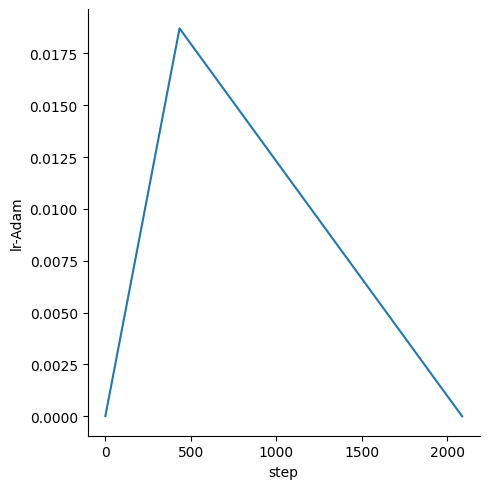

In [25]:
import pandas as pd
import seaborn as sn
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
del metrics["epoch"]
metrics.set_index("step", inplace=True)
display(metrics.dropna(axis=1, how="all").head())
sn.relplot(data=metrics['lr-Adam'], kind="line")